In [26]:
import dgl
import networkx as nx
%matplotlib inline

import collections
import re
import pandas as pd

In [62]:
nx_G = nx.read_graphml('./tmp/k_truss_k5_2dim.graphml')
# nx_G = nx.read_graphml('./tmp/g1000.graphml')

In [63]:
node_degree_dict=nx.degree(nx_G)
nx_G= nx.subgraph(nx_G,[x for x in nx_G.nodes() if node_degree_dict[x]>=4 and node_degree_dict[x] <=25 ])
len(nx_G.nodes())

32

In [64]:
count = 0
for u, v, attr in nx_G.edges(data=True):
    nx.set_edge_attributes(nx_G, {(u,v):{'id':count, 'weight':attr['weight']}})
    count = count +1
# nx_G.nodes(data=True)

In [65]:
nodes = list(nx_G)

G = dgl.DGLGraph()
G.from_networkx(nx_G)
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 32 nodes.
We have 232 edges.


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

feat_num = 5
hidden_num = 5
embed = nn.Embedding(G.number_of_nodes(), feat_num)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [67]:
# print out node 2's input feature
print(G.ndata['feat'][2])
# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([-6.7294e-01, -1.1489e+00,  7.1194e-04, -8.6627e-01, -1.3580e+00],
       grad_fn=<SelectBackward>)
tensor([[ 0.0103,  0.3026,  0.8022, -0.4653,  1.4151],
        [-0.6439, -1.7274, -0.7125,  0.3892, -0.1579]],
       grad_fn=<IndexBackward>)


In [68]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h


In [69]:
nodes

['ELECTRODE CATALYST LAYER',
 'DISPLAY APPARATUS',
 'WIRING BOARD',
 'SOLID-STATE IMAGE SENSOR',
 'ITS MANUFACTURING METHOD',
 'ELECTRODE ASSEMBLY',
 'ELECTRONIC COMPONENT',
 'ELECTRONIC DEVICE',
 'ELECTROCHEMICAL DEVICE',
 'MEMBRANE ELECTRODE ASSEMBLY',
 'MEMBRANE-ELECTRODE ASSEMBLY',
 'ELECTRONIC INSTRUMENT',
 'A METHOD',
 'ELECTRO-OPTICAL DEVICE',
 'RESIN COMPOSITION',
 'CIRCUIT BOARD',
 'ELECTRONIC EQUIPMENT',
 'FUEL CELL SYSTEM',
 'DRIVING METHOD',
 'ELECTRONIC APPARATUS',
 'SEMICONDUCTOR DEVICE',
 'POLYMER ELECTROLYTE FUEL CELL',
 'CONTROL METHOD',
 'LIQUID CRYSTAL DISPLAY DEVICE',
 'ELECTRODE MATERIAL',
 'PIXEL CIRCUIT',
 'FUEL CELL',
 'SOI WAFER',
 'DISPLAY PANEL',
 'DISPLAY DEVICE',
 'SILICON WAFER',
 'FUEL CELL STACK']

In [70]:
# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(feat_num, hidden_num, 2)

inputs = embed.weight
t = nodes.index('FUEL CELL SYSTEM')
f = nodes.index('MANUFACTURING METHOD')
labeled_nodes = torch.tensor([t, f])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different
print(t,f)

ValueError: 'MANUFACTURING METHOD' is not in list

In [46]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
epoch_num = 50

logits = net(G, inputs)
for epoch in range(epoch_num):
    net.train()
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7237
Epoch 1 | Loss: 0.7112
Epoch 2 | Loss: 0.7001
Epoch 3 | Loss: 0.6894
Epoch 4 | Loss: 0.6790
Epoch 5 | Loss: 0.6707
Epoch 6 | Loss: 0.6632
Epoch 7 | Loss: 0.6564
Epoch 8 | Loss: 0.6512
Epoch 9 | Loss: 0.6462
Epoch 10 | Loss: 0.6410
Epoch 11 | Loss: 0.6354
Epoch 12 | Loss: 0.6299
Epoch 13 | Loss: 0.6241
Epoch 14 | Loss: 0.6183
Epoch 15 | Loss: 0.6120
Epoch 16 | Loss: 0.6053
Epoch 17 | Loss: 0.5981
Epoch 18 | Loss: 0.5906
Epoch 19 | Loss: 0.5828
Epoch 20 | Loss: 0.5745
Epoch 21 | Loss: 0.5659
Epoch 22 | Loss: 0.5573
Epoch 23 | Loss: 0.5483
Epoch 24 | Loss: 0.5388
Epoch 25 | Loss: 0.5287
Epoch 26 | Loss: 0.5184
Epoch 27 | Loss: 0.5076
Epoch 28 | Loss: 0.4972
Epoch 29 | Loss: 0.4859
Epoch 30 | Loss: 0.4738
Epoch 31 | Loss: 0.4617
Epoch 32 | Loss: 0.4496
Epoch 33 | Loss: 0.4372
Epoch 34 | Loss: 0.4243
Epoch 35 | Loss: 0.4111
Epoch 36 | Loss: 0.3977
Epoch 37 | Loss: 0.3840
Epoch 38 | Loss: 0.3702
Epoch 39 | Loss: 0.3565
Epoch 40 | Loss: 0.3427
Epoch 41 | Loss: 0.3285
Ep

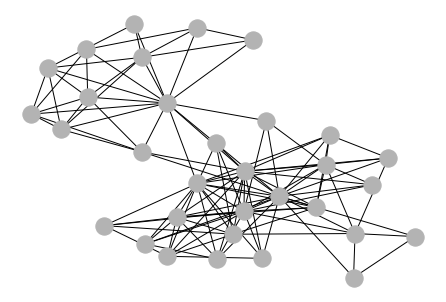

In [47]:
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=False, node_color=[[.7, .7, .7]])

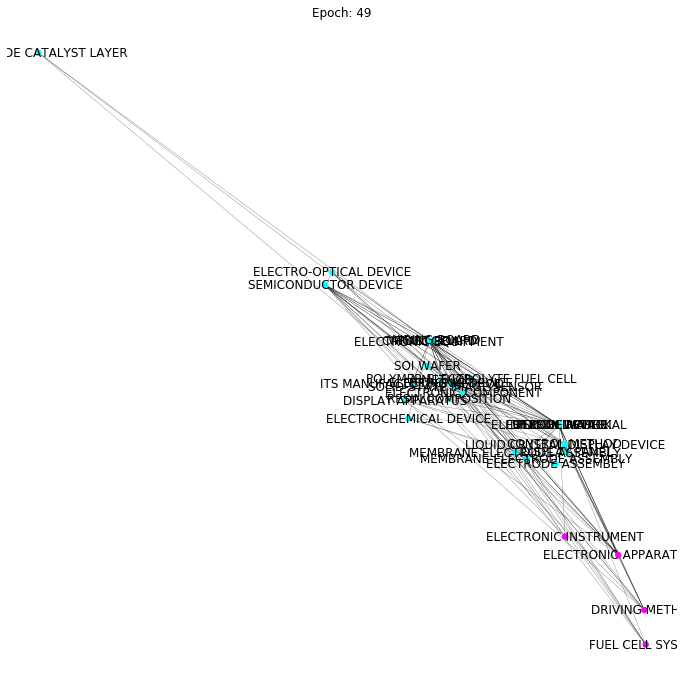

In [48]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(G.number_of_nodes()):
        pos[nodes[v]] = all_logits[i][v].numpy()
        cls = pos[nodes[v]].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
#     print(pos)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=30, ax=ax, width=0.2)
    return pos

fig = plt.figure(figsize=(12,12))
fig.clf()
ax = fig.subplots()
pos = draw(49)  # draw the prediction of the first epoch
plt.show()

In [49]:
# ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X = scale.fit_transform(list(pos.values()))

Projecting 2-dimensional data to 2D


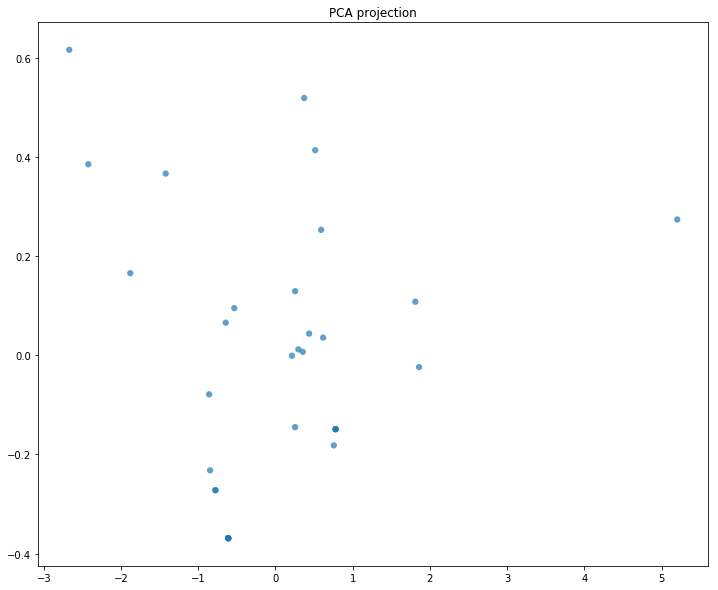

In [51]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
X_reduced.shape

print('Projecting %d-dimensional data to 2D' % X.shape[1])
plt.figure(figsize=(12,10))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1],edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
# plt.colorbar()
plt.title('PCA projection');


In [52]:
X_reduced = [x[1] for x in list(X_reduced)]

In [53]:
pca = PCA(n_components=1)
pca.fit(X)
X_reduced = pca.transform(X)
X_reduced.shape

(32, 1)

Projecting 2-dimensional data to 1D


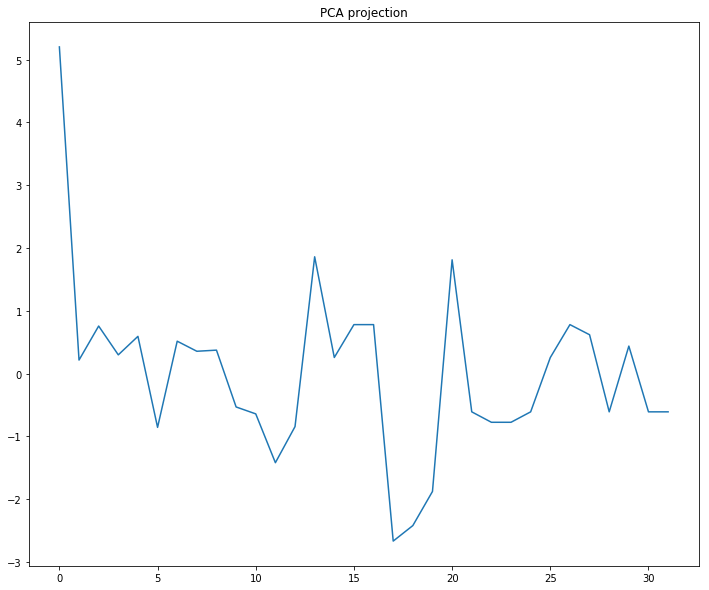

In [54]:
print('Projecting %d-dimensional data to 1D' % X.shape[1])
plt.figure(figsize=(12,10))

plt.plot(X_reduced[:, 0])
plt.title('PCA projection');

In [55]:
X_reduced = [x[0] for x in list(X_reduced)]

In [56]:
X_reduced

[5.202588392932985,
 0.2143550382277848,
 0.7562193813129349,
 0.2974056585881797,
 0.5921282225282622,
 -0.857903068489517,
 0.5148838268678954,
 0.3544612036298598,
 0.3723409948217582,
 -0.5327471030480582,
 -0.6430194323205736,
 -1.420499373817036,
 -0.8456425885435496,
 1.8594965411450124,
 0.2553547329474293,
 0.7788760420642998,
 0.7788760420642998,
 -2.6693249998732735,
 -2.4221529557534245,
 -1.8786801234356783,
 1.8109668920793764,
 -0.6104650436974721,
 -0.7767606840906676,
 -0.7767606840906676,
 -0.6104650436974721,
 0.254358655502088,
 0.7788760420642998,
 0.6176543637491185,
 -0.6104650436974721,
 0.43697420142422283,
 -0.6104650436974721,
 -0.6104650436974721]

In [57]:
zipped = zip(list(pos.keys()),X_reduced)
sorted_x = sorted(zipped, key = lambda t: t[1], reverse=True)
sorted_dict = collections.OrderedDict(sorted_x)

In [58]:
tf_df = pd.read_excel('./out/kw_dp_term_frequency_total.xlsx')

In [59]:
filter_dict = collections.OrderedDict()
re_ = r"^A |^THE |^THEIR |^ITS |^THIS |^AN |^SUCH A |^AS |^TO |^AND |^-PRON- |AT LEAST|USE THEREOF|^OR | THEREOF| THEREFOR| THERETO| THEREFROM| THEREBY"
for k, v in sorted_dict.items():
    k = re.sub(re_, "", k.upper())
    if  k.count(' ') < 4 and  k.count(' ') >= 1 and k.count('(') == 0 and k.count(')') == 0:
        if True or k.upper() in tf_df['Unnamed: 0'].values:
#             print(k.upper(),tf_df[tf_df['Unnamed: 0'] == k.upper()]['frequency'])
            tf_s = tf_df[tf_df['Unnamed: 0'] == k.upper()]['frequency']
            if not tf_s.empty and  tf_s.values[0] > 20 and k not in filter_dict:
                filter_dict[k] = (tf_s.values[0], v)
filter_df = pd.DataFrame(filter_dict).T.rename_axis('kw').add_prefix('value').reset_index()

In [60]:
filter_df.to_excel('./out/kws_dp_GCN_top1_2_pca2.xlsx')

In [61]:
filter_df

,kw,value0,value1
0,ELECTRODE CATALYST LAYER,23.0,5.202588
1,SEMICONDUCTOR DEVICE,2655.0,1.810967
2,CIRCUIT BOARD,174.0,0.778876
3,ELECTRONIC EQUIPMENT,109.0,0.778876
4,FUEL CELL,1597.0,0.778876
5,WIRING BOARD,137.0,0.756219
6,SOI WAFER,50.0,0.617654
7,MANUFACTURING METHOD,2593.0,0.592128
8,DISPLAY APPARATUS,142.0,0.514884
9,ELECTROCHEMICAL DEVICE,263.0,0.372341


In [8]:
nodes.index('SEMICONDUCTOR DEVICE')

31253

In [122]:
tf_df[tf_df['Unnamed: 0'] == 'OPERATING HYDROGEN GENERATING APPARATUS']['frequency'].values[0]

1

In [71]:
sorted_dict

OrderedDict([('ELECTRODE CATALYST LAYER', 5.202588392932985),
             ('ELECTRO-OPTICAL DEVICE', 1.8594965411450124),
             ('SEMICONDUCTOR DEVICE', 1.8109668920793764),
             ('CIRCUIT BOARD', 0.7788760420642998),
             ('ELECTRONIC EQUIPMENT', 0.7788760420642998),
             ('FUEL CELL', 0.7788760420642998),
             ('WIRING BOARD', 0.7562193813129349),
             ('SOI WAFER', 0.6176543637491185),
             ('ITS MANUFACTURING METHOD', 0.5921282225282622),
             ('DISPLAY APPARATUS', 0.5148838268678954),
             ('A METHOD', 0.43697420142422283),
             ('ELECTROCHEMICAL DEVICE', 0.3723409948217582),
             ('ELECTRONIC DEVICE', 0.3544612036298598),
             ('SOLID-STATE IMAGE SENSOR', 0.2974056585881797),
             ('RESIN COMPOSITION', 0.2553547329474293),
             ('POLYMER ELECTROLYTE FUEL CELL', 0.254358655502088),
             ('ELECTRONIC COMPONENT', 0.2143550382277848),
             ('MEMBRANE ELECTRO